In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

In [2]:
# create directory if not exist
INPUT_DIR = '../data'
OUTPUT_DIR = '../out'
IMG_DIR = '../img'
assert(Path(INPUT_DIR).is_dir())
Path(OUTPUT_DIR).mkdir(parents=True, exist_ok=True)
Path(IMG_DIR).mkdir(parents=True, exist_ok=True)

# Data

## Load Training Data

In [3]:
training_file = INPUT_DIR + '/covid_training.tsv'
train_df = pd.read_csv(training_file, sep='\t', usecols=[0,1,2])
train_df.head()

,tweet_id,text,q1_label
0,1241025578527903750,For the average American the best way to tell ...,no
1,1240467080954228737,this is fucking bullshit,no
2,1240716889162018816,Can y’all please just follow the government’s ...,no
3,1241062514886090754,No offense but the corona virus disappearing b...,no
4,1241447017945223169,This is the face of someone who just spent 9 h...,yes


In [4]:
X_train = pd.Series(train_df['text'].str.lower().str.split().values.copy(), index=train_df['tweet_id'])
X_train

tweet_id
1241025578527903750    [for, the, average, american, the, best, way, ...
1240467080954228737                        [this, is, fucking, bullshit]
1240716889162018816    [can, y’all, please, just, follow, the, govern...
1241062514886090754    [no, offense, but, the, corona, virus, disappe...
1241447017945223169    [this, is, the, face, of, someone, who, just, ...
                                             ...                        
1237310167814791168    [it's, like, suicide, but, minus, the, haram, ...
1237460460749766657    [the, first, silicon, valley, death, from, cov...
1237068715314892802    [breakthrough:, chloroquine, phosphate, --, an...
1237395939171561472    [i, know, everyone, is, freaking, out, about, ...
1237404677307760640    [ebola, has, a, 50%, death, rate., if, you, go...
Length: 399, dtype: object

In [5]:
y_train = pd.Series(train_df['q1_label'].astype('category').values.copy(), index=train_df['tweet_id'])
print(dict(enumerate(y_train.cat.categories)))

{0: 'no', 1: 'yes'}


## Load Test Data

In [6]:
testing_file = INPUT_DIR + '/covid_test_public.tsv'
test_df = pd.read_csv(testing_file, sep='\t', usecols=[0,1,2], names=train_df.columns)
X_test = pd.Series(test_df['text'].str.lower().str.split().values.copy(), index=test_df['tweet_id'])
y_test = pd.Series(test_df['q1_label'].astype('category').values.copy(), index=test_df['tweet_id'])
test_df.head()

,tweet_id,text,q1_label
0,1236932313642143745,1/ Many of you ask me why I take the COVID-19 ...,no
1,1236289649737371648,Panic buying and stockpiling of toilet roll co...,yes
2,1237501242567544835,Everyone can help prevent the spread of #COVID...,no
3,1237029903112888321,Isa sa pinakamaganda mong maa-ambag about COVI...,no
4,1237270988334592001,BREAKING: Department of Health announces 11 mo...,yes


## Inspect Data

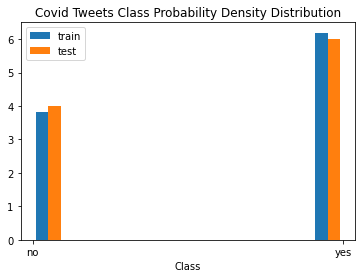

In [7]:
plt.hist([train_df['q1_label'], test_df['q1_label']], density=True, label=['train','test'])
plt.title('Covid Tweets Class Probability Density Distribution')
plt.xlabel('Class')
plt.legend()
plt.savefig(IMG_DIR + '/class_dist')

In [8]:
# Check for empty/too short tweets
print('Minimum length of tweets: ', X_train.apply(len).min())

Minimum length of tweets:  4


In [9]:
# Check for unknown classes
y_train.unique()

['no', 'yes']
Categories (2, object): ['no', 'yes']

# Model

In [10]:
CLASSES = y_train.unique()
CLASSES

['no', 'yes']
Categories (2, object): ['no', 'yes']

## Build Vector Space Representation

In [11]:
from collections import Counter
vec_space_df = pd.DataFrame(X_train.apply(Counter).tolist(), index=X_train.index).fillna(0)
vec_space_df.iloc[:5,-5:]

,obviously,ebolaâbut,34x,https://t.co/bcyoeedray,https://t.co/ga2rdghpiq
tweet_id,,,,,
1241025578527903750,0.0,0.0,0.0,0.0,0.0
1240467080954228737,0.0,0.0,0.0,0.0,0.0
1240716889162018816,0.0,0.0,0.0,0.0,0.0
1241062514886090754,0.0,0.0,0.0,0.0,0.0
1241447017945223169,0.0,0.0,0.0,0.0,0.0


## Class Probability

In [12]:
class_log_prior = np.log10((y_train.value_counts()/len(y_train)))
class_log_prior

yes   -0.208276
no    -0.419129
dtype: float64

## Vocabulary Probability

In [13]:
# P(w | c) = freq / total
ov_word_freqs = pd.DataFrame(dtype=int)
ov_word_totals = pd.Series(dtype=int)

In [14]:
fv_word_freqs = pd.DataFrame(dtype=int)
fv_word_totals = pd.Series(dtype=int)

### Count Words

In [15]:
for c in CLASSES:
    # frequency per class c = sum all rows where target is c
    ov_word_freqs[c] = vec_space_df[y_train==c].sum().astype(int)
# total per class = sum all word freqs where target is c
ov_word_totals = ov_word_freqs.sum().astype(int)
print('OV Word Frequencies')
print(ov_word_freqs)
print('\nOV Word Totals')
print(ov_word_totals)

OV Word Frequencies
                          no  yes
for                       34   90
the                      132  321
average                    1    0
american                   4    7
best                       4    2
...                      ...  ...
obviously                  0    1
ebolaâbut                0    1
34x                        0    1
https://t.co/bcyoeedray    0    1
https://t.co/ga2rdghpiq    0    1

[4304 rows x 2 columns]

OV Word Totals
no     3741
yes    8844
dtype: int32


In [16]:
# fv: mask out words with frequency less than 2
mask_less_than_2 = ov_word_freqs.sum(axis=1) >= 2

fv_word_freqs = ov_word_freqs.loc[mask_less_than_2].copy()
fv_word_totals = fv_word_freqs.sum().astype(int)

print('FV Word Frequencies')
print(fv_word_freqs)
print('\nFV Word Totals')
print(fv_word_totals)

FV Word Frequencies
              no  yes
for           34   90
the          132  321
american       4    7
best           4    2
way            5    6
...          ...  ...
ng             0    2
na             0    2
60s.           0    2
chloroquine    0    2
rate.          0    2

[1193 rows x 2 columns]

FV Word Totals
no     2833
yes    6641
dtype: int32


### Smoothing

In [17]:
delta = 0.01
ov_word_freqs += delta
ov_word_totals += delta * len(ov_word_freqs)
print('OV Smoothed Word Totals')
print(ov_word_totals)

fv_word_freqs += delta
fv_word_totals += delta * len(fv_word_freqs)
print('\nFV Smoothed Word Totals')
print(fv_word_totals)

OV Smoothed Word Totals
no     3784.04
yes    8887.04
dtype: float64

FV Smoothed Word Totals
no     2844.93
yes    6652.93
dtype: float64


In [18]:
# unit testing
assert(ov_word_totals['no'] == 3784.04)
assert(fv_word_totals['no'] == 2844.93)

### Word Probability

In [19]:
ov_model = np.log10(ov_word_freqs / ov_word_totals)
fv_model = np.log10(fv_word_freqs / fv_word_totals)

# Prediction and Evaluation

## Define Functions

### Trace Files

In [20]:
# implemented with pandas and numpy, see nb_bow_classifier.py
from nb_bow_classifier import predict, trace_predict

### Overall Evaluation Files

In [21]:
# implemented with pandas, seaborn and matplotlib, see metrics.py
from metrics import confusion_matrix, plot_confusion_matrix, eval_model

## Evaluate

### NB-BOW-OV Outputs

In [22]:
# produce OV trace file
ov_trace = trace_predict(ov_model, class_log_prior, X_test, y_test, OUTPUT_DIR + '/trace_NB-BOW-OV.txt')
ov_trace.head()

,y_pred,score,y_true,verdict
tweet_id,,,,
1236932313642143745,no,-93.337704,no,correct
1236289649737371648,yes,-32.975585,yes,correct
1237501242567544835,yes,-105.332263,no,wrong
1237029903112888321,yes,-67.937261,no,wrong
1237270988334592001,yes,-47.230059,yes,correct


In [23]:
# evaluate OV model performance
eval_model(ov_trace.y_true, ov_trace.y_pred, OUTPUT_DIR + '/eval_NB-BOW-OV.txt')

,accuracy,precision,recall,f1
yes,0.672727,0.666667,0.909091,0.769231
no,0.672727,0.700000,0.318182,0.437500


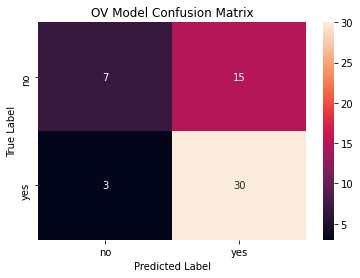

In [24]:
# plot OV confusion matrix
plot_confusion_matrix(ov_trace.y_true, ov_trace.y_pred)
plt.title('OV Model Confusion Matrix')
plt.savefig(IMG_DIR + '/ov_conf_mat')

### NB-BOW-FV Outputs

In [25]:
# produce FV trace file
fv_trace = trace_predict(fv_model, class_log_prior, X_test, y_test, OUTPUT_DIR + '/trace_NB-BOW-FV.txt')
fv_trace.head()

,y_pred,score,y_true,verdict
tweet_id,,,,
1236932313642143745,yes,-70.447123,no,wrong
1236289649737371648,yes,-27.522219,yes,correct
1237501242567544835,yes,-89.033702,no,wrong
1237029903112888321,yes,-61.352197,no,wrong
1237270988334592001,yes,-37.455025,yes,correct


In [26]:
# evaluate FV model performance
eval_model(fv_trace.y_true, fv_trace.y_pred, OUTPUT_DIR + '/eval_NB-BOW-FV.txt')

,accuracy,precision,recall,f1
yes,0.745455,0.720930,0.939394,0.815789
no,0.745455,0.833333,0.454545,0.588235


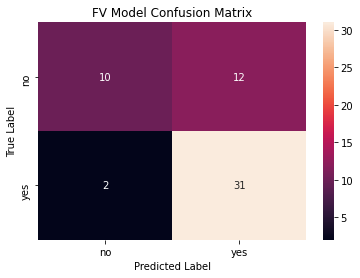

In [27]:
# plot FV confusion matrix
plot_confusion_matrix(fv_trace.y_true, fv_trace.y_pred)
plt.title('FV Model Confusion Matrix')
plt.savefig(IMG_DIR + '/fv_conf_mat')

### Evaluate LSTM-W2V model

     accuracy  precision    recall        f1
yes  0.763636   0.738095  0.939394  0.826667
no   0.763636   0.846154  0.500000  0.628571


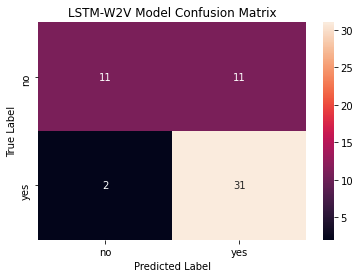

In [28]:
if (Path.cwd() / OUTPUT_DIR / 'trace_LSTM.txt').exists():
    lstm_trace = pd.read_csv(OUTPUT_DIR + '/trace_LSTM.txt', sep='  ', names=fv_trace.columns, index_col=0, engine='python')
    
    # evaluate LSTM-W2V model performance
    lstm_eval = eval_model(lstm_trace.y_true, lstm_trace.y_pred, OUTPUT_DIR + '/eval_LSTM.txt')
    print(lstm_eval)
    
    # plot FV confusion matrix
    plot_confusion_matrix(lstm_trace.y_true, lstm_trace.y_pred)
    plt.title('LSTM-W2V Model Confusion Matrix')
    plt.savefig(IMG_DIR + '/lstm_conf_mat')
    plt.show()